# Client orders :: *ipynb solution draft* <br>

## Read Data

In [10]:
# Import libraries

import order_functions as of

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from persiantools import jdatetime

from scipy.stats import boxcox
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Read data / Clean version of sales_data.csv

df = pd.read_csv("sales_data_clean.csv")
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,1396-10-26,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,1394-04-21,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,1402-05-24,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,1397-06-17,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,1392-09-30,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


In [12]:
# Convert Shamsi dates to Miladi

def vectorized_convert_shamsi_to_datetime(years, months, days):
    gregorian_dates = [
        jdatetime.JalaliDate(int(y), int(m), int(d)).to_gregorian()
        for y, m, d in zip(years, months, days)
    ]
    return pd.to_datetime(gregorian_dates)

years, months, days = zip(*df["Order_Date"].str.split("-").tolist())
df["Order_Date"] = vectorized_convert_shamsi_to_datetime(years, months, days)
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,2018-01-16,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,2015-07-12,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,2023-08-15,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,2018-09-08,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,2013-12-21,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


---

## Client Oder #3

پیرو درخواست قبلی برخی از مدیران شرکت می‌ترسند تخفیف دادن باعث کاهش سود شود برای همین از شما خواسته‌اند تا تاثیر تخفیف بر میزان سود را نیز بررسی کنید و در صورت وجود این تاثیر، آن را شرح دهید.

**Hypothesis**: <br>
"Discount has a significant impact on the sales' profit.” <br><br>

Null Hypothesis (**H<sub>0</sub>**): Discount has no significant impact on the profit. <br>
Alternative Hypothesis (**H<sub>a</sub>**): Discount has a significant impact on the profit.

In [13]:
# Filter & modify columns needed for analyze

cols_for_analyze_3 = [
    "Discount",
    "Profit",
]
df3 = df[cols_for_analyze_3].copy()

df3["Discount_Applied"] = df3["Discount"] > 0

df3.head()

,Discount,Profit,Discount_Applied
0,0,250000,False
1,0,380000,False
2,0,5630000,False
3,0,1130000,False
4,0,180000,False


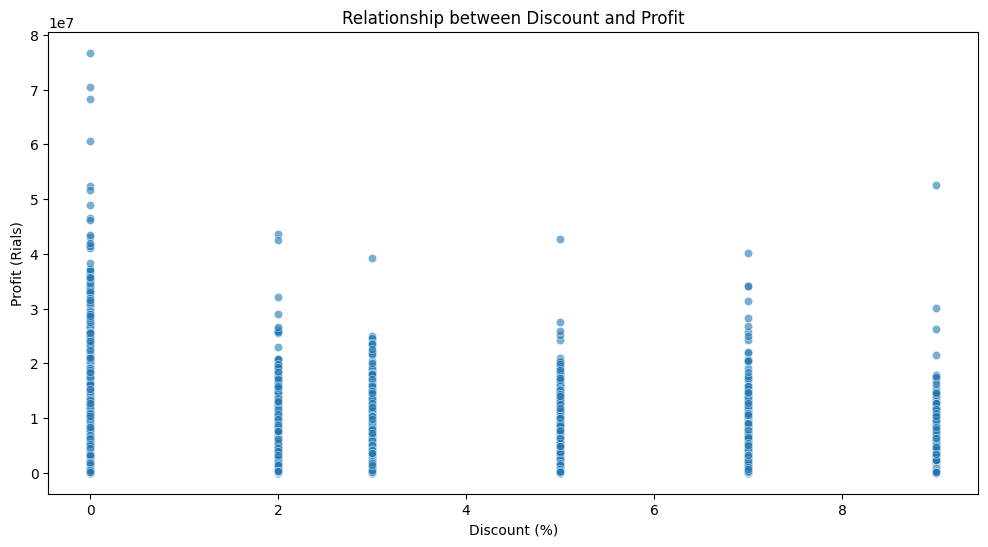

In [14]:
# Scatter plot between Discount and Profit

plt.figure(figsize=(12, 6))
sns.scatterplot(x=df3["Discount"], y=df3["Profit"], alpha=0.6)
plt.title("Relationship between Discount and Profit")
plt.xlabel("Discount (%)")
plt.ylabel("Profit (Rials)")
plt.show()

In [15]:
# Calculate the correlation between Discount and Profit

correlation = df3["Discount"].corr(df3["Profit"])

correlation

-0.013094112416811717

> This value is very close to zero, indicating a very weak negative linear relationship between discounts and profits. <br>
> Other factors might play a more critical role in determining the profit.

In [16]:
# Calculate the average profit for each discount group

average_profit_by_discount = df3.groupby("Discount_Applied")["Profit"].mean()

average_profit_by_discount

Discount_Applied
False    1.450280e+06
True     1.388569e+06
Name: Profit, dtype: float64

Average profit without discount    =   1_450_280  IRT <br>
Average profit with discount       =   1_388_569  IRT <br>

**Doesn't provide enough evidence**

In [17]:
# Split data into two groups: with discount and without discount

df3_with_discount = pd.DataFrame(df3[df3["Discount_Applied"] == True]["Profit"])
df3_without_discount = pd.DataFrame(df3[df3["Discount_Applied"] == False]["Profit"])

In [18]:
# Define function to plot two histograms above each other with mean values

def create_double_histogram(df1, df2, df1_label, df2_label, title, column_name="price"):
    mean_1 = df1[column_name].mean()
    mean_2 = df2[column_name].mean()

    plt.figure(figsize=(7, 5))
    sns.histplot(data=df1, x=column_name, color="blue", kde=True, label=df1_label)
    sns.histplot(data=df2, x=column_name, color="red", kde=True, label=df2_label)

    mean_text_y = plt.ylim()[1] / 2

    plt.axvline(mean_1, color="blue", linestyle="--")
    plt.text(mean_1, mean_text_y, f"{mean_1:,.2}", rotation=0, color="blue")

    plt.axvline(mean_2, color="red", linestyle="--")
    plt.text(mean_2, mean_text_y + 50, f"{mean_2:,.2}", rotation=0, color="red")

    plt.title(title, loc="center")
    plt.legend()
    plt.tight_layout()
    plt.show()

Skewness for applied discount sales: 3.71
Skewness for non-applied discount sales: 3.56


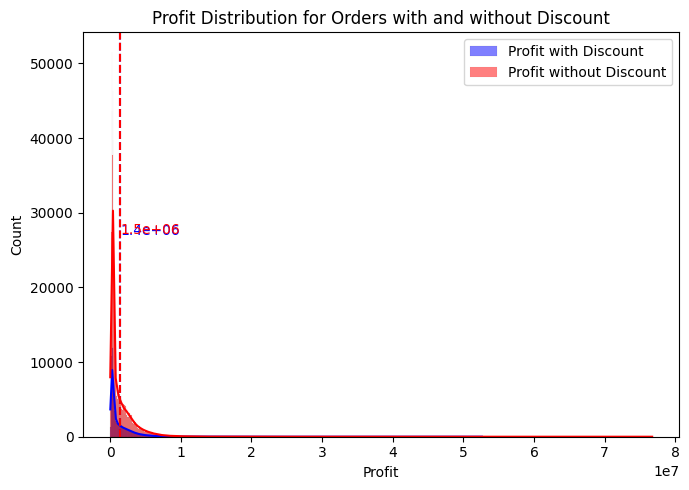

In [19]:
# Measure skewness for each group
# Plot the histogram for the final dataframes

skewness_profit_with_discount = df3_with_discount["Profit"].skew()
skewness_profit_without_discount = df3_without_discount["Profit"].skew()

print(f"Skewness for applied discount sales: {skewness_profit_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales: {skewness_profit_without_discount:,.2f}")

create_double_histogram(
    df3_with_discount,
    df3_without_discount,
    "Profit with Discount",
    "Profit without Discount",
    title="Profit Distribution for Orders with and without Discount",
    column_name="Profit",
)

Skewness for applied discount sales after boxcox transform: 0.05
Skewness for non-applied discount sales after boxcox transform: 0.05


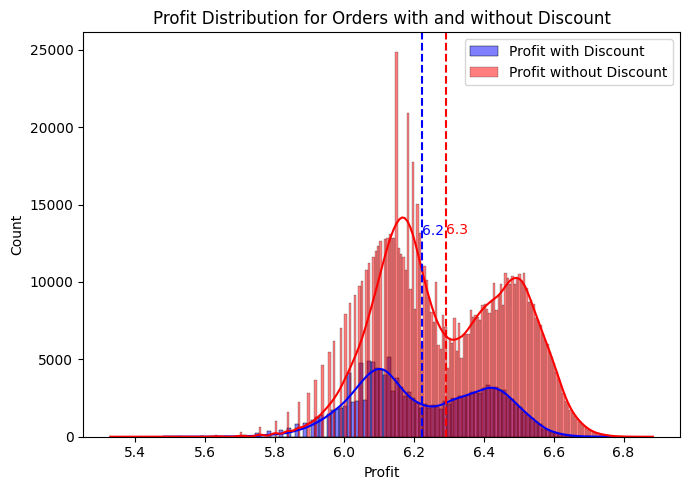

In [20]:
# Apply BOXCOX transformation for both groups
# Measure skewness for each group
# Plot the histogram for the final dataframes

df3_with_discount["Profit"], _ = boxcox(df3_with_discount["Profit"])
df3_without_discount["Profit"], _ = boxcox(df3_without_discount["Profit"])

skewness_profit_with_discount = df3_with_discount["Profit"].skew()
skewness_profit_without_discount = df3_without_discount["Profit"].skew()

print(f"Skewness for applied discount sales after boxcox transform: {skewness_profit_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales after boxcox transform: {skewness_profit_without_discount:,.2f}")

create_double_histogram(
    df3_with_discount,
    df3_without_discount,
    "Profit with Discount",
    "Profit without Discount",
    title="Profit Distribution for Orders with and without Discount",
    column_name="Profit",
)

In [21]:
# Apply t-test to check if the difference between two groups is significant

t_stat, p_value = ttest_ind(df3_with_discount["Profit"], df3_without_discount["Profit"])

print(f"t-statistic: {t_stat:.5f}")
print(f"p-value: {p_value:.20}")

t-statistic: -130.83815
p-value: 0.0


> P-Valye << **0.000** indicates that the observed data is extremely inconsistent with the null hypothesis. <br>
> T-STAT < **0** indicates increasing dicount rate relates to decreasing the profit but it can mean different things. <br>
    For instance, if the goal of the discount was to clear out old stock, then even if the revenue was lower with discounts, the strategy might still be deemed successful. <br><br>
> This leads to the **REJECTION** of the null hypothesis(H<sub>0</sub>) in favor of the alternative hypothesis (H<sub>a</sub>). <br><br>
> **This suggests that, based on the data, there is very strong evidence to conclude that applying discount on laptop sales has a significant impact on the Profit gained.** <br><br>
> Considering low correlation coefficient, it seems the discount is not the most strong or evident parameter effecting profit.

---